In [28]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile   # Neural networks keras: https://keras.io/api/applications/
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [29]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = "covid_2/train/"
CATEGORIES = ["Covid", "Viral-Pneumonia"]

# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224,224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the NASNetMobile network, ensuring the head FC layer sets are left off
baseModel = NASNetMobile(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))


# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] loading images...
19996672/19993432 [==============================] - 1s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/20
4/4 [==============================] - 8s 2s/step - loss: 0.8590 - accuracy: 0.4911 - val_loss: 0.6997 - val_accuracy: 0.5135
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.8524 - accuracy: 0.5000 - val_loss: 0.6136 - val_accuracy: 0.6486
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.6955 - accuracy: 0.6172 - val_loss: 0.5411 - val_accuracy: 0.7027
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.7797 - accuracy: 0.5893 - val_loss: 0.4841 - val_accuracy: 0.8108
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.5567 - accuracy: 0.7411 - val_loss: 0.4268 - val_accuracy: 0.8649
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 0.5653 - accuracy: 0.7232 - val_loss: 0.3770 - val_accuracy: 0.9459
Epoch 7/20
4/4 [======================

In [30]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving covid detector model...")
model.save("covid_detector.model", save_format="h5")

[INFO] evaluating network...
                 precision    recall  f1-score   support

          Covid       0.96      1.00      0.98        23
Viral-Pneumonia       1.00      0.93      0.96        14

       accuracy                           0.97        37
      macro avg       0.98      0.96      0.97        37
   weighted avg       0.97      0.97      0.97        37

[INFO] saving covid detector model...


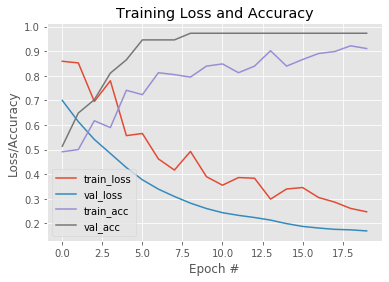

In [31]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


# Test

In [34]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse
import imutils
import time
import cv2
import os

[INFO] loading trained model for covid classification...


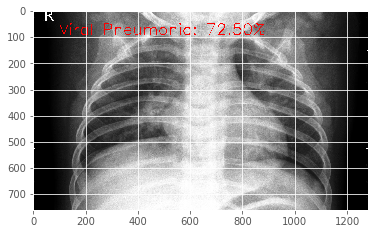

In [38]:
# Teste com uma imagem correspontende a Pneumonia viral
print("[INFO] loading trained model for covid classification...")
model = tf.keras.models.load_model('covid_detector.model')
image = cv2.imread("covid_2/test/Viral-Pneumonia/0105.jpeg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(covid, viralPneumonia) = model.predict(img)[0]
label = "Covid" if covid > viralPneumonia else "Viral Pneumonia"
color = (0, 255, 0) if label == "Covid" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(covid, viralPneumonia) * 100)
cv2.putText(image, label, (100, 100 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


[INFO] loading trained model for covid classification...


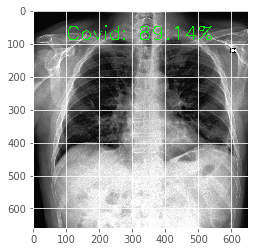

In [39]:
# Teste com uma contendo sinais de Covid 
print("[INFO] loading trained model for covid classification...")
model = tf.keras.models.load_model('covid_detector.model')
image = cv2.imread("covid_2/test/Covid/0100.jpeg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(covid, viralPneumonia) = model.predict(img)[0]
label = "Covid" if covid > viralPneumonia else "Viral Pneumonia"
color = (0, 255, 0) if label == "Covid" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(covid, viralPneumonia) * 100)
cv2.putText(image, label, (100, 100 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()
